In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'CatBoost-Plain特徴量ミニマム（カテゴリ変数指定）'
notebook_name = '058'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

058_submission.csv 058


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:

    clf = CatBoostClassifier(random_state=SEED,
                             cat_features=categorical_features,
                             train_dir=OUTPUT_DIR,
                             class_weights=CLASS_WEIGHTS,
                             boosting_type='Plain',
                             n_estimators=300,
                             learning_rate=0.01)
    return Pipeline(
        steps=[
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
# for c in categorical_features:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])

# train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
# test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

# categorical_features_1hot = []
# for c in categorical_features:
#     categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
# print(categorical_features_1hot)

# features = discrete_features + categorical_features_1hot
features = discrete_features + categorical_features

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['inningNo', 'S', 'totalPitchingCount', 'O', 'numRunners', 'B']


In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )

    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features)
#     class_weight = compute_class_weight('balanced',
#                                         classes=np.sort(train.y.unique()),
#                                         y=y_train.values)
#     class_weight = dict(
#         zip(
#             np.sort(train.y.unique()),
#             class_weight
#         )
#     )
#     sample_weight = y_train.map(class_weight)
#     assert(sample_weight.isnull().sum() == 0)
    sample_weight = None
    clf.fit(X_train,
            y_train.values,
            estimator__sample_weight=sample_weight)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



0:	learn: 2.0794323	total: 163ms	remaining: 48.9s
1:	learn: 2.0786962	total: 302ms	remaining: 45s
2:	learn: 2.0761559	total: 443ms	remaining: 43.9s
3:	learn: 2.0748604	total: 598ms	remaining: 44.3s
4:	learn: 2.0745035	total: 671ms	remaining: 39.6s
5:	learn: 2.0740761	total: 708ms	remaining: 34.7s
6:	learn: 2.0740676	total: 749ms	remaining: 31.3s
7:	learn: 2.0716771	total: 871ms	remaining: 31.8s
8:	learn: 2.0712654	total: 951ms	remaining: 30.7s
9:	learn: 2.0712222	total: 1s	remaining: 29s
10:	learn: 2.0697571	total: 1.12s	remaining: 29.4s
11:	learn: 2.0691208	total: 1.25s	remaining: 30.1s
12:	learn: 2.0676391	total: 1.37s	remaining: 30.2s
13:	learn: 2.0651176	total: 1.51s	remaining: 31s
14:	learn: 2.0650812	total: 1.56s	remaining: 29.6s
15:	learn: 2.0637998	total: 1.68s	remaining: 29.9s
16:	learn: 2.0635515	total: 1.75s	remaining: 29.2s
17:	learn: 2.0622195	total: 1.87s	remaining: 29.3s
18:	learn: 2.0610386	total: 1.99s	remaining: 29.5s
19:	learn: 2.0605616	total: 2.13s	remaining: 29.9s

162:	learn: 1.8769694	total: 18.2s	remaining: 15.3s
163:	learn: 1.8762471	total: 18.4s	remaining: 15.2s
164:	learn: 1.8747108	total: 18.5s	remaining: 15.1s
165:	learn: 1.8739028	total: 18.6s	remaining: 15s
166:	learn: 1.8733650	total: 18.8s	remaining: 14.9s
167:	learn: 1.8719114	total: 18.9s	remaining: 14.9s
168:	learn: 1.8710351	total: 19.1s	remaining: 14.8s
169:	learn: 1.8692231	total: 19.2s	remaining: 14.7s
170:	learn: 1.8680537	total: 19.4s	remaining: 14.6s
171:	learn: 1.8661707	total: 19.5s	remaining: 14.5s
172:	learn: 1.8647597	total: 19.6s	remaining: 14.4s
173:	learn: 1.8645492	total: 19.8s	remaining: 14.3s
174:	learn: 1.8624723	total: 19.9s	remaining: 14.2s
175:	learn: 1.8616001	total: 20.1s	remaining: 14.2s
176:	learn: 1.8593821	total: 20.3s	remaining: 14.1s
177:	learn: 1.8586503	total: 20.4s	remaining: 14s
178:	learn: 1.8576508	total: 20.6s	remaining: 13.9s
179:	learn: 1.8564866	total: 20.7s	remaining: 13.8s
180:	learn: 1.8555538	total: 21s	remaining: 13.8s
181:	learn: 1.8555

8:	learn: 2.0659347	total: 854ms	remaining: 27.6s
9:	learn: 2.0626592	total: 974ms	remaining: 28.2s
10:	learn: 2.0624577	total: 1.03s	remaining: 27.1s
11:	learn: 2.0624215	total: 1.06s	remaining: 25.6s
12:	learn: 2.0610184	total: 1.19s	remaining: 26.3s
13:	learn: 2.0578114	total: 1.33s	remaining: 27.2s
14:	learn: 2.0563927	total: 1.46s	remaining: 27.7s
15:	learn: 2.0562015	total: 1.53s	remaining: 27.2s
16:	learn: 2.0541339	total: 1.64s	remaining: 27.2s
17:	learn: 2.0513909	total: 1.77s	remaining: 27.7s
18:	learn: 2.0483775	total: 1.88s	remaining: 27.9s
19:	learn: 2.0474636	total: 1.96s	remaining: 27.5s
20:	learn: 2.0457499	total: 2.12s	remaining: 28.2s
21:	learn: 2.0453102	total: 2.18s	remaining: 27.5s
22:	learn: 2.0429967	total: 2.34s	remaining: 28.1s
23:	learn: 2.0417009	total: 2.46s	remaining: 28.3s
24:	learn: 2.0396656	total: 2.6s	remaining: 28.6s
25:	learn: 2.0378904	total: 2.73s	remaining: 28.8s
26:	learn: 2.0377871	total: 2.83s	remaining: 28.6s
27:	learn: 2.0348633	total: 2.97s	

170:	learn: 1.8825407	total: 18.9s	remaining: 14.3s
171:	learn: 1.8818724	total: 19.1s	remaining: 14.2s
172:	learn: 1.8810422	total: 19.2s	remaining: 14.1s
173:	learn: 1.8781260	total: 19.4s	remaining: 14.1s
174:	learn: 1.8768885	total: 19.6s	remaining: 14s
175:	learn: 1.8753740	total: 19.7s	remaining: 13.9s
176:	learn: 1.8739708	total: 19.9s	remaining: 13.8s
177:	learn: 1.8724839	total: 20s	remaining: 13.7s
178:	learn: 1.8720956	total: 20.1s	remaining: 13.6s
179:	learn: 1.8697746	total: 20.2s	remaining: 13.5s
180:	learn: 1.8679877	total: 20.4s	remaining: 13.4s
181:	learn: 1.8674771	total: 20.5s	remaining: 13.3s
182:	learn: 1.8669659	total: 20.6s	remaining: 13.2s
183:	learn: 1.8644446	total: 20.8s	remaining: 13.1s
184:	learn: 1.8638418	total: 20.9s	remaining: 13s
185:	learn: 1.8625702	total: 21s	remaining: 12.9s
186:	learn: 1.8621552	total: 21.1s	remaining: 12.7s
187:	learn: 1.8607838	total: 21.2s	remaining: 12.6s
188:	learn: 1.8594289	total: 21.3s	remaining: 12.5s
189:	learn: 1.858304

16:	learn: 2.0506060	total: 1.95s	remaining: 32.5s
17:	learn: 2.0474309	total: 2.1s	remaining: 32.9s
18:	learn: 2.0470121	total: 2.17s	remaining: 32s
19:	learn: 2.0450865	total: 2.33s	remaining: 32.6s
20:	learn: 2.0446073	total: 2.45s	remaining: 32.6s
21:	learn: 2.0430066	total: 2.6s	remaining: 32.8s
22:	learn: 2.0426102	total: 2.73s	remaining: 32.9s
23:	learn: 2.0407866	total: 2.88s	remaining: 33.2s
24:	learn: 2.0396813	total: 3.02s	remaining: 33.3s
25:	learn: 2.0394714	total: 3.1s	remaining: 32.7s
26:	learn: 2.0359222	total: 3.26s	remaining: 32.9s
27:	learn: 2.0330861	total: 3.39s	remaining: 33s
28:	learn: 2.0302138	total: 3.54s	remaining: 33.1s
29:	learn: 2.0284984	total: 3.68s	remaining: 33.2s
30:	learn: 2.0263023	total: 3.83s	remaining: 33.2s
31:	learn: 2.0249832	total: 3.96s	remaining: 33.1s
32:	learn: 2.0237007	total: 4.05s	remaining: 32.8s
33:	learn: 2.0234229	total: 4.11s	remaining: 32.1s
34:	learn: 2.0233913	total: 4.14s	remaining: 31.3s
35:	learn: 2.0225018	total: 4.29s	rema

178:	learn: 1.8451292	total: 21.3s	remaining: 14.4s
179:	learn: 1.8442545	total: 21.4s	remaining: 14.3s
180:	learn: 1.8428381	total: 21.6s	remaining: 14.2s
181:	learn: 1.8417292	total: 21.7s	remaining: 14.1s
182:	learn: 1.8416490	total: 21.8s	remaining: 13.9s
183:	learn: 1.8389348	total: 21.9s	remaining: 13.8s
184:	learn: 1.8382250	total: 22s	remaining: 13.7s
185:	learn: 1.8376214	total: 22.2s	remaining: 13.6s
186:	learn: 1.8367843	total: 22.3s	remaining: 13.5s
187:	learn: 1.8360679	total: 22.4s	remaining: 13.4s
188:	learn: 1.8351702	total: 22.6s	remaining: 13.3s
189:	learn: 1.8350650	total: 22.7s	remaining: 13.2s
190:	learn: 1.8344214	total: 22.9s	remaining: 13s
191:	learn: 1.8338244	total: 23s	remaining: 12.9s
192:	learn: 1.8325704	total: 23.1s	remaining: 12.8s
193:	learn: 1.8323190	total: 23.2s	remaining: 12.7s
194:	learn: 1.8316400	total: 23.4s	remaining: 12.6s
195:	learn: 1.8293607	total: 23.5s	remaining: 12.5s
196:	learn: 1.8293604	total: 23.5s	remaining: 12.3s
197:	learn: 1.8280

25:	learn: 2.0509057	total: 2.76s	remaining: 29.1s
26:	learn: 2.0472561	total: 2.89s	remaining: 29.2s
27:	learn: 2.0465377	total: 3s	remaining: 29.1s
28:	learn: 2.0456438	total: 3.13s	remaining: 29.3s
29:	learn: 2.0448953	total: 3.2s	remaining: 28.8s
30:	learn: 2.0446154	total: 3.31s	remaining: 28.7s
31:	learn: 2.0444301	total: 3.42s	remaining: 28.7s
32:	learn: 2.0437083	total: 3.51s	remaining: 28.4s
33:	learn: 2.0417193	total: 3.64s	remaining: 28.5s
34:	learn: 2.0398188	total: 3.76s	remaining: 28.5s
35:	learn: 2.0394860	total: 3.83s	remaining: 28.1s
36:	learn: 2.0375055	total: 3.96s	remaining: 28.2s
37:	learn: 2.0374896	total: 4s	remaining: 27.6s
38:	learn: 2.0347287	total: 4.13s	remaining: 27.6s
39:	learn: 2.0347054	total: 4.17s	remaining: 27.1s
40:	learn: 2.0332065	total: 4.22s	remaining: 26.7s
41:	learn: 2.0311936	total: 4.34s	remaining: 26.7s
42:	learn: 2.0296030	total: 4.46s	remaining: 26.7s
43:	learn: 2.0294296	total: 4.59s	remaining: 26.7s
44:	learn: 2.0293854	total: 4.64s	rema

188:	learn: 1.8851683	total: 20.3s	remaining: 11.9s
189:	learn: 1.8840184	total: 20.4s	remaining: 11.8s
190:	learn: 1.8833773	total: 20.6s	remaining: 11.7s
191:	learn: 1.8833167	total: 20.6s	remaining: 11.6s
192:	learn: 1.8821332	total: 20.8s	remaining: 11.5s
193:	learn: 1.8820194	total: 20.8s	remaining: 11.4s
194:	learn: 1.8811787	total: 20.9s	remaining: 11.3s
195:	learn: 1.8805382	total: 21.1s	remaining: 11.2s
196:	learn: 1.8803597	total: 21.2s	remaining: 11.1s
197:	learn: 1.8803595	total: 21.2s	remaining: 10.9s
198:	learn: 1.8796055	total: 21.3s	remaining: 10.8s
199:	learn: 1.8783304	total: 21.5s	remaining: 10.7s
200:	learn: 1.8783302	total: 21.5s	remaining: 10.6s
201:	learn: 1.8765977	total: 21.6s	remaining: 10.5s
202:	learn: 1.8750059	total: 21.8s	remaining: 10.4s
203:	learn: 1.8739347	total: 21.9s	remaining: 10.3s
204:	learn: 1.8732800	total: 22s	remaining: 10.2s
205:	learn: 1.8727659	total: 22.1s	remaining: 10.1s
206:	learn: 1.8719219	total: 22.3s	remaining: 10s
207:	learn: 1.87

34:	learn: 2.0291335	total: 4.16s	remaining: 31.5s
35:	learn: 2.0291333	total: 4.2s	remaining: 30.8s
36:	learn: 2.0279353	total: 4.31s	remaining: 30.7s
37:	learn: 2.0267333	total: 4.41s	remaining: 30.4s
38:	learn: 2.0237811	total: 4.54s	remaining: 30.4s
39:	learn: 2.0230222	total: 4.66s	remaining: 30.3s
40:	learn: 2.0217702	total: 4.79s	remaining: 30.3s
41:	learn: 2.0204940	total: 4.91s	remaining: 30.2s
42:	learn: 2.0200168	total: 5.03s	remaining: 30.1s
43:	learn: 2.0199344	total: 5.11s	remaining: 29.8s
44:	learn: 2.0175964	total: 5.23s	remaining: 29.6s
45:	learn: 2.0168768	total: 5.36s	remaining: 29.6s
46:	learn: 2.0157053	total: 5.5s	remaining: 29.6s
47:	learn: 2.0129880	total: 5.65s	remaining: 29.6s
48:	learn: 2.0126669	total: 5.79s	remaining: 29.7s
49:	learn: 2.0112768	total: 5.91s	remaining: 29.6s
50:	learn: 2.0075925	total: 6.08s	remaining: 29.7s
51:	learn: 2.0074164	total: 6.12s	remaining: 29.2s
52:	learn: 2.0046711	total: 6.27s	remaining: 29.2s
53:	learn: 2.0024742	total: 6.42s

194:	learn: 1.8430991	total: 24.8s	remaining: 13.4s
195:	learn: 1.8411228	total: 25s	remaining: 13.3s
196:	learn: 1.8397497	total: 25.2s	remaining: 13.2s
197:	learn: 1.8395997	total: 25.4s	remaining: 13.1s
198:	learn: 1.8378743	total: 25.7s	remaining: 13.1s
199:	learn: 1.8367354	total: 26.1s	remaining: 13.1s
200:	learn: 1.8348314	total: 26.4s	remaining: 13s
201:	learn: 1.8335142	total: 26.6s	remaining: 12.9s
202:	learn: 1.8320242	total: 27s	remaining: 12.9s
203:	learn: 1.8311680	total: 27.2s	remaining: 12.8s
204:	learn: 1.8305763	total: 27.6s	remaining: 12.8s
205:	learn: 1.8291024	total: 28s	remaining: 12.8s
206:	learn: 1.8280876	total: 28.3s	remaining: 12.7s
207:	learn: 1.8276483	total: 28.6s	remaining: 12.6s
208:	learn: 1.8274086	total: 28.8s	remaining: 12.6s
209:	learn: 1.8269345	total: 29.2s	remaining: 12.5s
210:	learn: 1.8264333	total: 29.5s	remaining: 12.5s
211:	learn: 1.8261250	total: 29.8s	remaining: 12.4s
212:	learn: 1.8254118	total: 30.1s	remaining: 12.3s
213:	learn: 1.825411

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.135036,0.130178
std,0.003127,0.006561
min,0.129883,0.123373
25%,0.135301,0.124384
50%,0.135726,0.129491
75%,0.135869,0.135487
max,0.138400,0.138155


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,5,0,1
3,3,2,5,0,1
4,4,4,5,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.119262,0.119480,0.138697,0.137282,0.125333,0.156193,0.080289,0.123463,27446,1
1,0.141408,0.124741,0.156052,0.132085,0.123393,0.124804,0.091632,0.105886,113,1
2,0.158478,0.161961,0.136489,0.115384,0.105410,0.106455,0.108823,0.107000,4479,1
3,0.157995,0.161440,0.139474,0.121937,0.105163,0.109921,0.085103,0.118967,29080,1
4,0.138974,0.131751,0.143276,0.128238,0.117846,0.137970,0.080931,0.121015,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.143008,0.178849,0.128349,0.135808,0.122669,0.098891,0.086936,0.105490,24272,5
33804,0.114199,0.122088,0.153600,0.162299,0.137001,0.125810,0.088094,0.096910,29106,5
33805,0.112946,0.119936,0.163020,0.169317,0.139332,0.130186,0.053211,0.112052,20679,5
33806,0.139405,0.140044,0.154159,0.154213,0.134129,0.110625,0.073741,0.093684,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,0.699631,0.813857,0.671355,0.696337,0.628225,0.571401,0.306644,0.612551
1,1,0.777745,0.859633,0.614297,0.613239,0.574195,0.552180,0.394897,0.613814
2,2,0.606912,0.579917,0.746247,0.754809,0.737666,0.598840,0.398864,0.576746
3,3,0.757681,0.879965,0.609502,0.606447,0.575269,0.554760,0.412801,0.603575
4,4,0.801824,0.823706,0.640997,0.587347,0.567497,0.548607,0.427900,0.602121
...,...,...,...,...,...,...,...,...,...
33803,33803,0.727752,0.726308,0.671063,0.693432,0.630731,0.575815,0.366011,0.608888
33804,33804,0.771657,0.835060,0.623001,0.617561,0.589354,0.581946,0.350827,0.630594
33805,33805,0.781707,0.824011,0.612956,0.611475,0.597024,0.560806,0.320510,0.691512
33806,33806,0.608239,0.690337,0.738901,0.779853,0.722776,0.656898,0.315603,0.487393


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,1
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.071019
1    0.527656
2    0.091369
3    0.259436
4    0.016209
5    0.006892
6    0.002425
7    0.024994
Name: y, dtype: float64

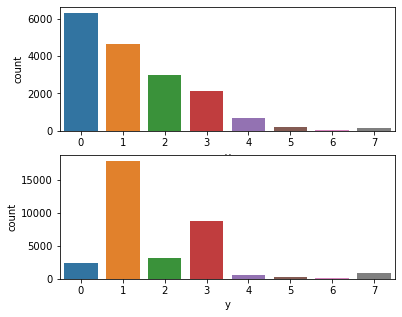

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.13503602042245105, 0.1301779451227824)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"058_submission.csv","Stratified-Kfold(K=5)","0.135036","0.130178","","CatBoost-Plain特徴量ミニマム（カテゴリ変数指定）"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 77 ms


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 17 ms


In [21]:
imp_df

,feature,importance,fold
0,inningNo,0.910628,1
1,S,5.490864,1
2,totalPitchingCount,2.566706,1
3,O,4.472068,1
4,numRunners,1.563371,1
...,...,...,...
13,isPitcherHandLeft,0.284497,5
14,isBatterPitcher,0.000000,5
15,isBottom,0.436292,5
16,batterTeam,10.352954,5


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
